In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db =mysql.connector.connect(host ="localhost",
                            username ="root",
                            password ="124567",
                            database ="ecommerce")
cur =db.cursor()

<!-- List all unique cities where customers are located. -->

# List all unique cities where customers are located.

In [2]:
query =""" select distinct(customer_city) as customer_city from customers"""

cur.execute(query)
data =cur.fetchall()

df =pd.DataFrame(data ,columns=["customer_city"])
df

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


 # Count  the number of orders placed in 2017.

In [3]:
query =""" select count(distinct order_id) from orders where year (order_purchase_timestamp) =2017"""

cur.execute(query)
data =cur.fetchall()
data[0][0], "total orders placed in 2017 are"

(45101, 'total orders placed in 2017 are')

# Find the total sales per category.

In [4]:
query = """ select  `product category` ,round(sum(payments.payment_value),2) as sales 
FROM products JOIN order_items 
ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY  `product category`,payments.payment_value;

"""
cur.execute(query)

data = cur.fetchall()

df= pd.DataFrame(data, columns=["category", "Sales"])
df

,category,Sales
0,perfumery,5519.64
1,Furniture Decoration,43.12
2,telephony,135.93
3,bed table bath,362.17
4,automotive,207.24
...,...,...
62850,Watches present,427.98
62851,Fashion Bags and Accessories,26.16
62852,Garden tools,492.53
62853,party articles,269.73


# Calculate the percentage of orders that were paid in installments.

In [5]:
query = """
SELECT (SUM(CASE WHEN payment_installments >= 1 THEN 1
                ELSE 0 
           END))/count(*)*100 AS installment_count
FROM payments
"""

cur.execute(query)
data = cur.fetchall()
"Calculate the percentage of orders that were paid in installments is ", data[0][0]

('Calculate the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# List all unique cities where customers are located.

In [6]:
query =""" select distinct customer_city from customers """

cur.execute(query)
data =cur.fetchall()
df =pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of customers from each state.

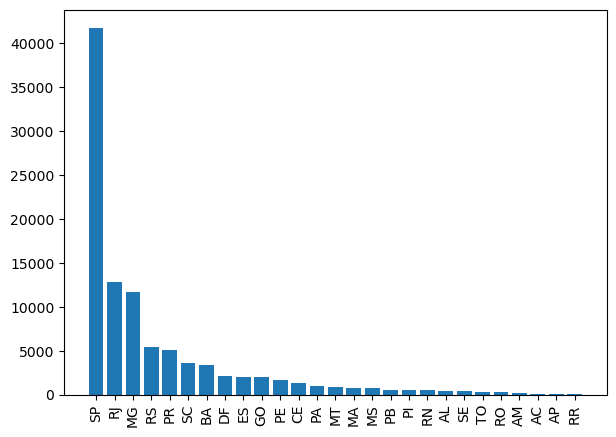

In [7]:
query =""" select customer_state, count(customer_id) from customers group by 
customer_state 
"""
cur.execute(query)
data =cur.fetchall()
df =pd.DataFrame(data, columns=["state", "customer_count"])
df =df.sort_values(by="customer_count", ascending=False)
plt.figure(figsize= (7,5))
plt.bar(df["state"], df["customer_count"])

plt.xticks(rotation =90)
plt.show()

# Calculate the number of orders per month in 2018.

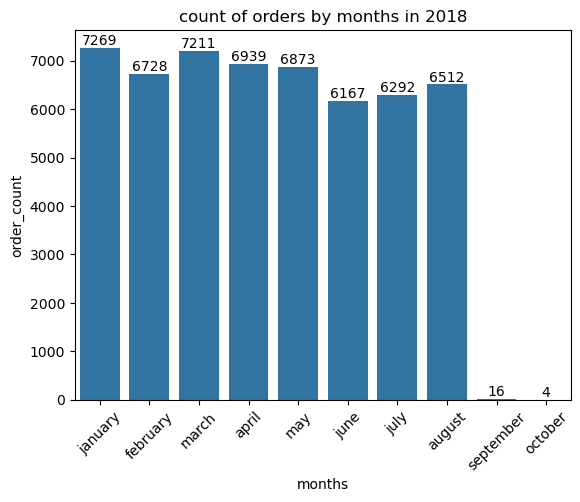

In [8]:
import calendar

query = """
SELECT MONTH(order_purchase_timestamp) AS month,
       COUNT(order_id) AS order_count
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018 
GROUP BY MONTH(order_purchase_timestamp)
"""

cur.execute(query)
data = cur.fetchall()

# Convert month number to lowercase month name
df = pd.DataFrame(data, columns=["month_num", "order_count"])
df["months"] = df["month_num"].apply(lambda x: calendar.month_name[x].lower())

o = ["january", "february", "march", "april", "may", "june",
     "july", "august", "september", "october"]

ax = sns.barplot(x="months", y="order_count", data=df, order=o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("count of orders by months in 2018")
plt.show()


# Find the average number of products per order, grouped by customers city.

In [9]:
query= """with count_per_order as
(SELECT 
    orders.order_id,
    orders.customer_id,
    COUNT(order_items.order_id) AS oc
FROM ecommerce.orders
JOIN order_items ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT 
    customers.customer_city, 
    round(AVG(count_per_order.oc),2) AS avg_items_per_order
FROM ecommerce.customers 
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
"""

cur.execute(query)
data =cur.fetchall()
df =pd.DataFrame(data ,columns=["customer_city" ,"average_products/order"])
df


,customer_city,average_products/order
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,buriti,3.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


# Calcualate the percentage of total revenue contributed by each produt category.

In [10]:
query = """SELECT 
    upper(products.`product category`) category,
    round((SUM(payments.payment_value)/(select sum(payment_value) from payments)) *100 ,2)
 AS sales
FROM 
    products
JOIN 
    order_items ON products.product_id = order_items.product_id
JOIN 
    payments ON payments.order_id = order_items.order_id
GROUP BY 
    category order by sales
"""
cur.execute(query)
data =cur.fetchall()
df =pd.DataFrame(data ,columns=["category"  ,"price"])
df

,category,price
0,INSURANCE AND SERVICES,0.00
1,FASHION CHILDREN'S CLOTHING,0.00
2,ARTS AND CRAFTS,0.01
3,FLOWERS,0.01
4,PC GAMER,0.01
...,...,...
68,FURNITURE DECORATION,8.93
69,WATCHES PRESENT,8.93
70,COMPUTER ACCESSORIES,9.90
71,HEALTH BEAUTY,10.35


# Identify the correlation between product price and he nuber of times a product has been purchased.

In [11]:
query = """select products.`product category`, 
count(order_items.product_id),
round(avg(order_items.product_id),0)

from products join order_items on  
products.product_id = order_items.product_id
group by  products.`product category`
"""

cur.execute(query)
data =cur.fetchall()
df =pd.DataFrame(data ,columns=["category" ,"order_count","price"])
arr1 =df["order_count"]
arr2 =df["price"]
a = np.corrcoef([arr1,arr2])
print(a[0][-1] ,"the correlation is")

nan the correlation is


C:\Users\intel\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\intel\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Calculate the total revenue generated by each seller and rank them by revenue.

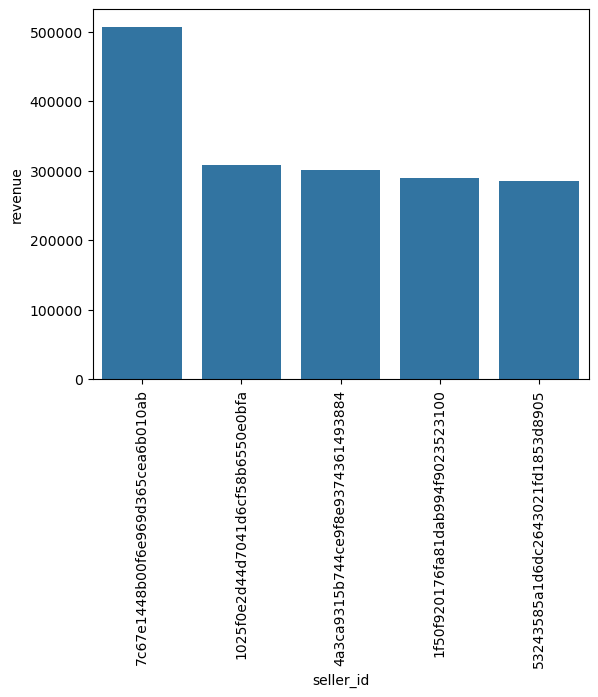

In [12]:
query = """SELECT 
    seller_id,
    revenue, DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn
FROM (
    SELECT 
        oi.seller_id,
        round(SUM(p.payment_value) ,2)AS revenue
    FROM order_items oi JOIN payments p ON oi.order_id = p.order_id
    GROUP BY oi.seller_id
) AS a;

"""
cur.execute(query)
data =cur.fetchall()
df =pd.DataFrame(data ,columns =["seller_id" ,"revenue", "rank"])
df =df.head()
sns.barplot(x= "seller_id", y ="revenue", data = df)
plt.xticks(rotation =90)
plt.show()

# Calculate the moving average of order values for each customer over their hestory.

In [13]:
query =""" SELECT 
    customer_id,
    order_purchase_timestamp,
    payment_value,
    AVG(payment_value) OVER (
        PARTITION BY customer_id 
        ORDER BY order_purchase_timestamp ROWS BETWEEN 2 PRECEDING AND CURRENT ROW ) AS mov_avg FROM 
        ( 
        SELECT 
        o.customer_id, o.order_purchase_timestamp, p.payment_value
    FROM 
        payments p  JOIN  orders o ON p.order_id = o.order_id
) AS a;
"""
cur.execute(query)
data =cur.fetchall()
df =pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,9.49,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


# Calculate the cumulative sales per month for each year 

In [34]:
query =  """select years, months ,sum(payment_value) over(order by years , months)
cumulative_sales from 
(select year (orders.order_purchase_timestamp)as years,
month(orders.order_purchase_timestamp)as months,
round(sum(payments.payment_value),2) as payment_value from orders join payments 
on orders.order_id =payments.order_id
group by years, months order by years , months) as a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years","month","cumulative_sales"])
df.head()


,years,month,cumulative_sales
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39


# Calculate the year over-year growth rate of total sales.

In [15]:
query = """with a as (select year (orders.order_purchase_timestamp)as years,

round(sum(payments.payment_value),2) as payment_value from orders join payments 
on orders.order_id =payments.order_id
group by years order by years)

select years,((payment_value -lag(payment_value ,1) over(order by years))/
lag(payment_value ,1) over(order by years))*100 from a
"""
cur.execute(query)
data =cur.fetchall()
df =pd.DataFrame(data ,columns= ["years","total_sales"])
df

,years,total_sales
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Caculate the retention rate of customers , defined as the percentage of customers who make another purchase within 6 month of their first puchase.

In [20]:
query = """
WITH first_orders AS (
    SELECT 
        c.customer_id,
        MIN(o.order_purchase_timestamp) AS first_order
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    GROUP BY c.customer_id
),
repeat_customers AS (
    SELECT 
        f.customer_id
    FROM first_orders f
    JOIN orders o 
        ON o.customer_id = f.customer_id
        AND o.order_purchase_timestamp > f.first_order
        AND o.order_purchase_timestamp < DATE_ADD(f.first_order, INTERVAL 6 MONTH)
    GROUP BY f.customer_id
)
SELECT 
    100.0 * COUNT(DISTINCT r.customer_id) / COUNT(DISTINCT f.customer_id) AS repeat_customer_percentage
FROM first_orders f
LEFT JOIN repeat_customers r ON f.customer_id = r.customer_id;

"""
cur.execute(query)
data =cur.fetchall()
data

[(Decimal('0.00000'),)]

# Identify the top 3 customers who spent the most money in each years

<function matplotlib.pyplot.show(close=None, block=None)>

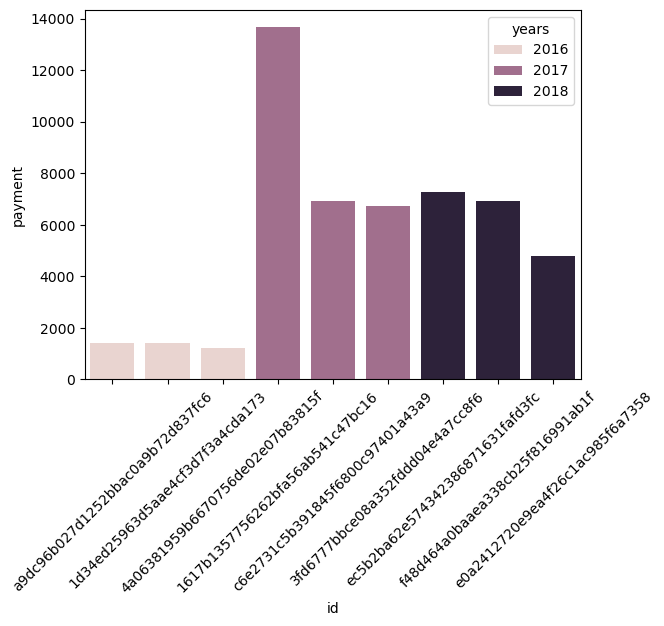

In [25]:
query = """ SELECT 
    years, 
    customer_id,
    payment,
    d_rank
FROM (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS years,
        o.customer_id,
        SUM(p.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(o.order_purchase_timestamp) 
            ORDER BY SUM(p.payment_value) DESC
        ) AS d_rank
    FROM orders o
    JOIN payments p ON p.order_id = o.order_id
    GROUP BY 
        YEAR(o.order_purchase_timestamp), 
        o.customer_id
) AS ranked_payments
WHERE d_rank <= 3;

"""
cur.execute(query)
data =cur.fetchall()
df =pd.DataFrame(data, columns=["years", "id" ,"payment","rank"])
sns.barplot(x ="id", y ="payment", data =df, hue ="years")
plt.xticks(rotation =45)
plt.show